In [13]:
### Imports ###
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import os
from scipy.optimize import curve_fit
cosmo = FlatLambdaCDM(H0=70, Om0=0.27)
from GalPop import *
from tqdm.notebook import tqdm

----
----
----
----


<font size = 7><h1 align = center>Creating pops for original sample</h1 ></font>      


In [14]:
### PREP ###

## Set limits
ra_range = (149.6, 150.52)  
dec_range = (1.74, 2.73)
z_range = (2., 3.)
IRAC_cut = 25.4


## Interpolated sigma cube
sig_cube = fits.open(r"C:\Users\sikor\OneDrive\Desktop\benpy\ThirdTry\Hyperion_interpolated_cube_sigma.fits")

## Path for folders with .dat sigma files
sigPath = r"C:\Users\sikor\OneDrive\Desktop\benpy\HyperionPeaks"


<font size = 5><h1 align = center>Handle Photometric sources</h1 ></font>    

Make a broad cut on RA, Dec, z, IRAC mag, and lp_type, and then save to GalPop

In [15]:
## CUT DATA AND SAVE ##

## Load Cosmos
cosmos = fits.open(r"C:\Users\sikor\OneDrive\Desktop\BigData\COSMOS2020\COSMOS2020_CLASSIC_R1_v2.0.fits")
c20p = cosmos[1].data

## Apply cut
g_idxs = np.where((c20p["ALPHA_J2000"] >= ra_range[0]) & (c20p["ALPHA_J2000"] <= ra_range[1])       # RA
                & (c20p["DELTA_J2000"] >= dec_range[0]) & (c20p["DELTA_J2000"] <= dec_range[1])     # DEC
                & ((c20p["IRAC_CH1_MAG"] <= IRAC_cut) | (c20p["IRAC_CH2_MAG"] <= IRAC_cut)) # IRAC
                & (c20p["lp_zPDF"] >= z_range[0]) & (c20p["lp_zPDF"] <= z_range[1])       # Redshift
                & ((c20p["lp_type"] == 0) | (c20p["lp_type"] == 2)))        # LePhare type

c20p_cut = c20p[g_idxs] # cosmos photometry

## Make GalPop and save
p_misc = {'Age': c20p_cut["lp_age"], 'survey' :np.full(len(c20p_cut), 'C20p')}
IRAC_mags = np.min(np.c_[c20p_cut["IRAC_CH1_MAG"], c20p_cut["IRAC_CH2_MAG"]], axis=1)

og_c20p = GalPop(IDs = c20p_cut["ID"], ms = c20p_cut["lp_MASS_MED"], obs_type=np.zeros(len(c20p_cut["ID"])), 
                coords = np.c_[c20p_cut["ALPHA_J2000"], c20p_cut["DELTA_J2000"] , c20p_cut["lp_zPDF"]],
                SFRs=c20p_cut["lp_SFR_MED"], misc=p_misc, mags={'IRAC': IRAC_mags})
og_c20p.saveFile("OG_c20p.npy")


print(f"Cosmos catalog = {np.shape(c20p)}")
print(f"Potentially good galaxies = {np.shape(c20p_cut)}")

Cosmos catalog = (1720700,)
Potentially good galaxies = (45356,)


<font size = 5><h1 align = center>Handle Spectra sources</h1 ></font>    

In [16]:
### LOAD SPECTRA ###

# GROUND-BASED (GB)
specz_cat = np.loadtxt("./Data/master_specz_COSMOS_BF_v4b.cat", dtype=object)   # Load in the data
# Fix up the formatting for the spec data-file:
new_array = []
for idx in range(specz_cat.shape[1]):
    try:
        col = specz_cat[:,idx].astype(np.float32)
    except:
        col = specz_cat[:,idx]
    new_array.append(col)

c20s = np.array(new_array, dtype=object)
c20s = np.transpose(c20s)

print(f"Number of C20 spectra: {c20s.shape[0]}")

# ----------------------------------------------------------------------
# ----------------------------------------------------------------------

# GRISM
griz_cat = np.loadtxt("./Data/HST_galfits_v1.2.cat", dtype=object)   # Load in the data
# Fix up the formatting for the spec data-file:
new_array = []
for idx in range(griz_cat.shape[1]):
    try:
        col = griz_cat[:,idx].astype(np.float32)
    except:
        col = griz_cat[:,idx]
    new_array.append(col)

griz = np.array(new_array, dtype=object)
griz = np.transpose(griz)

# Need blended flags from griz_cat
griz_rs_cat = np.loadtxt("./Data/HST_Hyp_zcat.v1.2.cat",  usecols=range(16), dtype=object)   # Load in the data
bfs = griz_rs_cat[:,5].astype(int)

print(f"Number of Grism redshifts: {griz.shape[0]}")

Number of C20 spectra: 42776
Number of Grism redshifts: 12764


Make a cut based on the IRAC CH1 and CH2 Mag for the object in COSMOS2020. Also check if there is a meaningful mass measurement (i.e. it's not zero)

In [17]:
## MAKE MAG CUT AND CHECK MASS ##
    # Find idx in original C20 cat and cut based on mag
    # Check if mass exists (i.e. is positive)

## GB

spec_cids = c20s[:,0].astype(int) - 1   
spec_gals = c20p[spec_cids]
g_spec = np.where(((spec_gals["IRAC_CH1_MAG"] <= IRAC_cut) | (spec_gals["IRAC_CH2_MAG"] <= IRAC_cut))
                  & (c20s[:,15] > 0))
c20s = c20s[g_spec]

## GRISM

griz_cids = griz[:,5].astype(int)  -1
griz_gals = c20p[griz_cids]
g_griz = np.where(((griz_gals["IRAC_CH1_MAG"] <= IRAC_cut) | (griz_gals["IRAC_CH2_MAG"] <= IRAC_cut))
                  & (griz[:,6] > 0))
griz = griz[g_griz]
bfs = bfs[g_griz]

print("POST IRAC CUT")
print(f"Number of C20 spectra: {c20s.shape[0]}")
print(f"Number of Grism redshifts: {griz.shape[0]}")

POST IRAC CUT
Number of C20 spectra: 29257
Number of Grism redshifts: 12270


Figure out which objects have both GB and Grism observations. Make unique catalogs for grism and GB measurements w/ these removed. In the similar catalog, remove the blended objects.

In [18]:
## FIND COMMON OBJECTS ##

sim_objs = []   # Keep track of idxs of the object --> [spec_id, griz_id, cosmos id]

# Check if the cosmos id is in the spec catalog, and add to list if it is
for g_id, c_id in enumerate(griz[:,5]):

    if c_id > 0:    # Make sure it's a cosmos object (not -99)
        s_ids = np.where(c_id == c20s[:,0])[0]
        for si in s_ids:
            sim_objs.append([s_ids[0], g_id, c_id, bfs[g_id]])

sim_objs = np.array(sim_objs, dtype=int)

# Create unique catalogs
spec_unique = np.delete(c20s, sim_objs[:,0], axis=0)
griz_unique = np.delete(griz, sim_objs[:,1], axis=0)
bfs_unique = np.delete(bfs, sim_objs[:,1])

# Delete similar objects that have blended flag in grism spec
blended = np.where(sim_objs[:,-1] == 1)
sim_objs = np.delete(sim_objs, blended, axis=0)

print(f"Unique Grizli Objects = {len(griz_unique)}")
print(f"Unique Spec Objects = {len(spec_unique)}")
print(f"Common Objects = {len(sim_objs)}    ({len(blended[0])} were removed b/c of blending)")

Unique Grizli Objects = 10328
Unique Spec Objects = 27343
Common Objects = 1886    (56 were removed b/c of blending)


Cut the GB measurements based on RA, Dec, z, and qf. Note we've already cut based on magnitude and if there's a mass

In [19]:
### Narrow down the spec-targets ###

qfs = spec_unique[:,13] % 10        # Find last digit of qf

spec_use_idxs = np.where( (ra_range[0]<= spec_unique[:,4]) & (spec_unique[:,4] <= ra_range[1])          # RA check
                 & (dec_range[0] <= spec_unique[:,6]) & (spec_unique[:,6] <= dec_range[1])      # Dec check
                 & (z_range[0] <= spec_unique[:,11]) & (spec_unique[:,11]<= z_range[1])         # redshift check
                 & (  ((qfs >=2.)&(qfs<3.))  |  ((qfs>=9.)&(qfs<10.)) | ((qfs>=3.)&(qfs<5.)))   )[0] # QF check         


spec_use = spec_unique[spec_use_idxs]     # Trim the spec catalog to only include galaxies I care about
print("Good spectra: ", len(spec_use))

Good spectra:  1864


Narrow down the Grism targets based on RA, Dec, z, qfs, and if it's blended. Note we've already trimmed based on IRAC and if there's a mass.

In [20]:
### Narrow down the griz-targets ###

qfs = griz_unique[:,4]  

griz_use_idxs = np.where( (ra_range[0]<= griz_unique[:,1]) & (griz_unique[:,1] <= ra_range[1])          # RA check
                 & (dec_range[0] <= griz_unique[:,2]) & (griz_unique[:,2] <= dec_range[1])      # Dec check
                 & (z_range[0] <= griz_unique[:,3]) & (griz_unique[:,3]<= z_range[1])         # redshift check
                 & (  (qfs==3)  |  (qfs==4) | (qfs==5) )        # QF check
                 & (bfs_unique== 0))[0]          # Not a blended object

griz_use = griz_unique[griz_use_idxs]     # Trim the spec catalog to only include galaxies I care about
print("Good Grism spectra: ", len(griz_use))

Good Grism spectra:  512


For similar objects, we need to figure out the best object with both observations based on the quality flag. For Qs and Qg, the ranking goes:

Qs=3/4 > Qg=5 > Qg=4 > Qs2/9 > Qg=3


Note these objects are checked for RA, Dec, and z later

In [21]:
### Figure out the best of the similar objects ###

qf_s = c20s[sim_objs[:,0]][:,13] %10
qf_g = griz[sim_objs[:,1]][:,4]

which_choice = []   # 1 for spec, 2 for griz, -99 for bad quality

# qs_3/4 > qg_5 > qg_4 > qs_2/9 > qg_3

for s, g in zip(qf_s, qf_g):

        if (s>=3.) and (s<5.): which_choice.append(1)       # qs == 3/4
        elif g in [5,4]:  which_choice.append(2)            # qg == 5 or 4
        elif ((s >=2.)and(s<3.)) or ((s>=9.)and(s<10.)): which_choice.append(1)   # qs = 2 or 9
        elif g == 3: which_choice.append(2)
        else: which_choice.append(-99)

# Find and remove bad quality objects
bad_objs = np.where(which_choice==-99)  
sim_objs = np.delete(sim_objs, bad_objs, axis=0)
which_choice = np.delete(which_choice, bad_objs)

print("Number of spectra: ", len(which_choice[which_choice==1]))
print("Number of grism: ", len(which_choice[which_choice==2]))
print("Number total = ", len(which_choice))
print("Number of bad objects ", len(bad_objs[0]))


Number of spectra:  1414
Number of grism:  325
Number total =  1886
Number of bad objects  0


<font size = 5><h1 align = center>Make catalog</h1 ></font>    

We now have:
- A GalPop Object for the good photometric data
- A list of unique, usable Ground-Based spectra
- A list of unique, usable Grism spectra
- A list of the IDs for potentially usable similar objects that need an RA/Dec/z check still

Let's combine combine the spectra into another GalPop, then combine the GalPops

In [22]:

## Prep the GB Spectra ##
s_obs = np.ones(len(spec_use))  # obs type = 1 for spectra
s_IDs = spec_use[:,0].astype(int)       # C20 ID
s_survey = spec_use[:,2]        # which survey
s_coords  = np.c_[spec_use[:,4], spec_use[:,6], spec_use[:,11]]    # spec (ra, dec, z)
s_ms = spec_use[:,15]    # Spec m
s_sfr = spec_use[:,18]   # sfr
s_age = spec_use[:,21]   # age
s_qf = spec_use[:,13] %10
s_imag = np.min(   np.c_[c20p['IRAC_CH1_MAG'][s_IDs-1], c20p['IRAC_CH1_MAG'][s_IDs-1]], axis=1)


## Prep the Grism Spec ##
g_obs = 2*np.ones(len(griz_use))     # obs type = 2 for grizli
g_survey = np.full(len(griz_use), 'HST')    # Which survey
g_IDs = griz_use[:,5].astype(int)   # C20 ID
g_coords  = np.c_[griz_use[:,1], griz_use[:,2], griz_use[:,3]]     # grizli coords
g_ms = griz_use[:,6]    # mass
g_sfr = griz_use[:,9]   # sfr
g_age = griz_use[:,11]   # age
g_qf = griz_use[:,4]
g_imag = np.min(   np.c_[c20p['IRAC_CH1_MAG'][g_IDs-1], c20p['IRAC_CH1_MAG'][g_IDs-1]], axis=1)

derek = []
## Prep the common objects ##
    # Note we still need to check RA/dec/z
com_typ = []
com_ids, com_survey,  com_coords, com_ms, com_sfr, com_age, com_qf, com_imag = [], [], [], [], [], [], [], []
for idx, t in enumerate(which_choice):
    if t == 1:  # Using a GB-spec
        s_id = sim_objs[idx][0]
        props = c20s[s_id]
        # Make sure the galaxy is in right range
        if (ra_range[0]<= props[4]<=ra_range[1]) and (dec_range[0]<=props[6]<=dec_range[1])and(z_range[0]<=props[11]<=z_range[1]):
            com_typ.append(1)
            com_survey.append(props[2])
            com_ids.append(props[0])
            com_coords.append([props[4], props[6], props[11]])
            com_ms.append(props[15])
            com_sfr.append(props[18])
            com_age.append(props[21])
            com_qf.append(props[13]%10)
            derek.append(props[13])
            c = np.int32(props[0]-1)
            com_imag.append( np.min( (c20p['IRAC_CH1_MAG'][c], c20p['IRAC_CH1_MAG'][c] )) )

        else:
            continue

    elif t==2:  # Using Grism
        g_id = sim_objs[idx][1]
        props = griz[g_id]
        if (ra_range[0]<= props[1]<=ra_range[1]) and (dec_range[0]<=props[2]<=dec_range[1])and(z_range[0]<=props[3]<=z_range[1]):
            com_typ.append(2)
            com_survey.append('HST')
            com_ids.append(props[5])
            com_coords.append([props[1], props[2], props[3]])
            com_ms.append(props[6])
            com_sfr.append(props[9])
            com_age.append(props[11])
            com_qf.append(props[4])
            c = np.int32(props[5]-1)
            com_imag.append( np.min( (c20p['IRAC_CH1_MAG'][c], c20p['IRAC_CH1_MAG'][c]) ) )

        else:
            continue

# Flatten on the lists into one array
spec_obs = np.concatenate((s_obs, g_obs, com_typ))
spec_ids = np.concatenate((s_IDs, g_IDs, com_ids ))
spec_survey = np.concatenate((s_survey, g_survey, com_survey))
spec_coords = np.concatenate((s_coords, g_coords, com_coords ), axis=0)
spec_ms = np.concatenate((s_ms, g_ms, com_ms))
spec_sfr = np.concatenate((s_sfr, g_sfr, com_sfr))
spec_age = np.concatenate((s_age, g_age, com_age))
spec_qf = np.concatenate((s_qf, g_qf, com_qf))
imags = np.concatenate((s_imag, g_imag, com_imag))

# Add the misc info and make object
spec_misc = {'Age': spec_age, 'survey': spec_survey}
spec_gp = GalPop(IDs=spec_ids.astype(int), ms=spec_ms.astype(float), coords=spec_coords,
                SFRs=spec_sfr.astype(float), obs_type=spec_obs, misc=spec_misc, mags={'IRAC': imags})

# Delete the similar objects from the photometric catalog and combine
og_c20p.del_objs(spec_gp.IDs)
final_tot = spec_gp.combine(og_c20p)

# Find breakdown of galaxies

print("Final number of objects = ", len(final_tot.IDs))
print("Photo-z sources = ", len(final_tot.obs_type[final_tot.obs_type == 0]))
print("Spec-z sources = ", len(final_tot.obs_type[final_tot.obs_type == 1]))
print("Grism-z sources = ", len(final_tot.obs_type[final_tot.obs_type == 2]))


Final number of objects =  45964
Photo-z sources =  43306
Spec-z sources =  2078
Grism-z sources =  580


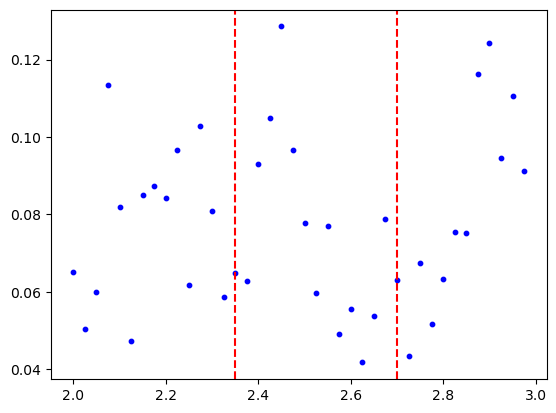

In [26]:
dz = 0.025

for z in np.arange(2,3,dz):
    z_id = np.where((final_tot.coords[:,2]>=z) & (final_tot.coords[:,2]<z+dz))

    frac = len(np.where(final_tot.obs_type[z_id] == 0)[0]) / len(final_tot.obs_type[z_id])


    plt.scatter(z,1-frac, color='b', s=10 )


plt.axvline(2.35, color='r', ls='--')
plt.axvline(2.7, color='r', ls='--')
plt.show()

40


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0.]),
 array([2.  , 2.05, 2.1 , 2.15, 2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 ,
        2.55, 2.6 , 2.65, 2.7 , 2.75, 2.8 , 2.85, 2.9 , 2.95]),
 <BarContainer object of 19 artists>)

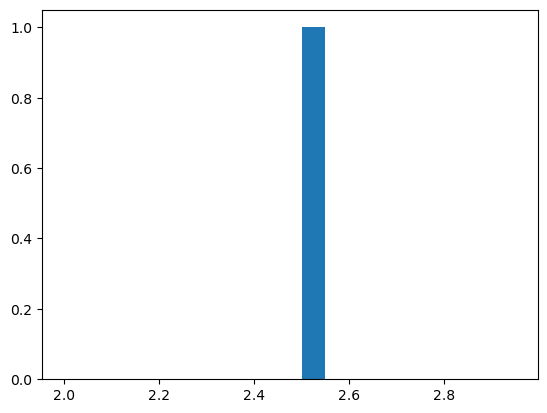

In [11]:
test_qf = np.concatenate((spec_use[:,13], derek))
hm = len(np.where(((test_qf >= 10) & (test_qf < 20)) | (test_qf > 100))[0])
print(hm)
plt.hist(spec_coords[:,2][hm], bins=np.arange(2,3,0.05))

(array([ 0.,  0.,  0., 86., 11.,  2.]),
 array([0., 1., 2., 3., 4., 5., 6.]),
 <BarContainer object of 6 artists>)

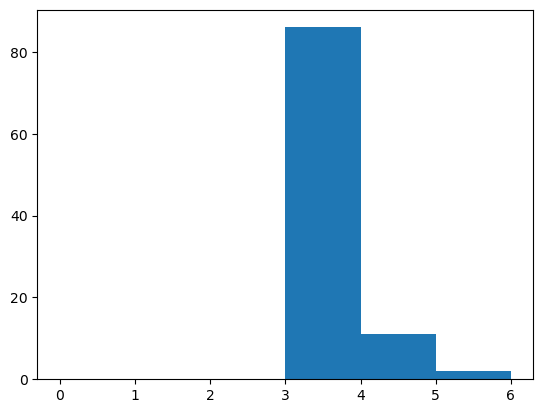

In [39]:
gi = np.where(((g_coords[:,2] >=2.35) & (g_coords[:,2] <=2.55)))
plt.hist(g_qf[gi], bins=np.arange(7))


(array([  0.,   0., 826., 648., 279.,   0.,   0.,   0.,  47.]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <BarContainer object of 9 artists>)

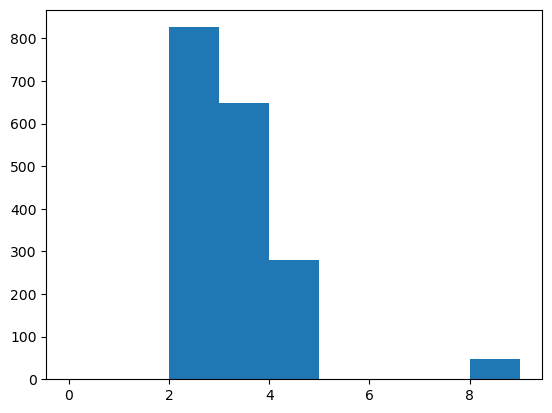

In [32]:
plt.hist(s_qf, bins=np.arange(0,10,1))

In [12]:
# Define sigma information
sigs = np.arange(2.0, 5.5, 0.5)
sig_path = sigPath
sig_sums = [f"\peaks_sig{s}.dat" for s in sigs]
sig_folders = [f"\sig{s}_peaks" for s in sigs]

# Assign peaks to objects
spec_gp.assignPeaks(sigs, sig_cube, sig_path, sig_sums, sig_folders, overwrite=True)

In [30]:
s = np.where((spec_gp.obs_type == 1) & (2.35 <= spec_gp.coords[:,2]) & (2.7 >= spec_gp.coords[:,2]) & (spec_gp.pks[2.0]==1))
plt.hist(spec_qf[s], bins=np.arange(0,11,1))

KeyError: 2.0

In [75]:
0.7*(39+7) + 0.993*(55+74)

160.297

(array([ 0.,  0.,  0., 47.,  7.,  2.,  0.,  0.,  0.,  0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

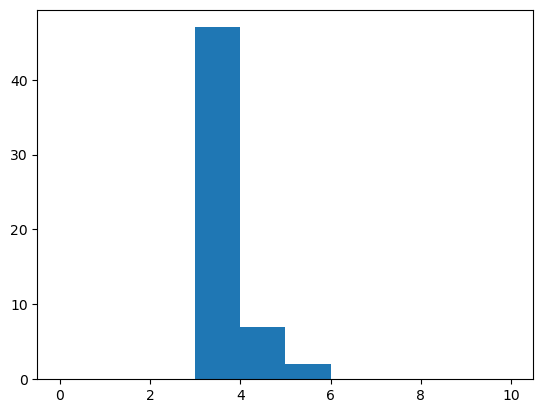

In [62]:
s = np.where((spec_gp.obs_type == 2) & (2.35 <= spec_gp.coords[:,2]) & (2.7 >= spec_gp.coords[:,2]) & (spec_gp.pks[2.0]==1))
plt.hist(spec_qf[s], bins=np.arange(0,11,1))

In [73]:
0.925*2 + 0.818*7 + 0.668*47

38.972

<font size = 5><h1 align = center>Assign Objects to peaks and make Subpops</h1 ></font>    

In [23]:
# Define sigma information
sigs = np.arange(2.0, 5.5, 0.5)
sig_path = sigPath
sig_sums = [f"\peaks_sig{s}.dat" for s in sigs]
sig_folders = [f"\sig{s}_peaks" for s in sigs]

# Assign peaks to objects
final_tot.assignPeaks(sigs, sig_cube, sig_path, sig_sums, sig_folders, overwrite=True)

# Make subpopulations based on this
pk_path = "HyperionPeaks_new/"
pk_sums = [f"peaks_sig{s}.dat" for s in sigs]


# Make field subpops
final_tot.subPop("field1", [-99, 4.0], 13. , [2.15, 2.25], pk_path, "peaks_sig4.0.dat", sig_cube, cosmo = cosmo, plot=f"popPlots/OG_Cosmos")
final_tot.subPop("field2", [-99, 4.0], 13. , [2.65, 2.75], pk_path, "peaks_sig4.0.dat", sig_cube, cosmo = cosmo, plot=f"popPlots/OG_Cosmos")

# Make overdense subpops
for si, sigma in enumerate(sigs):
    print(sigma)
    final_tot.subPop(f"ho{sigma}", [sigma, np.inf], 13., [2.35, 2.7], pk_path, pk_sums[si], sig_cube, plot=f"popPlots/OG_Cosmos")

final_tot.subPop(f"ho2.0", [2.0, np.inf], 13., [2.35, 2.7], pk_path, pk_sums[si], sig_cube, pk_nums=[1], plot=f"popPlots/OG_Cosmos")



final_tot.saveFile("OG_Cosmos.npy")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.0
2.5
3.0
3.5
4.0
4.5
5.0


---
---
---

# Assign Peaks to C20p

In [3]:
### LOAD DATA ###
# Cosmos data
cosmos = fits.open(r"C:\Users\sikor\OneDrive\Desktop\BigData\COSMOS2020\COSMOS2020_CLASSIC_R1_v2.0.fits")
c20p = cosmos[1].data

# MC iterations
MCp = np.load(rf"C:/Users/sikor/OneDrive/Desktop/BigData/COSMOS2020/C20_MC_100_0.npy")

## Interpolated sigma cube
sig_cube = fits.open(r"C:\Users\sikor\OneDrive\Desktop\benpy\ThirdTry\Hyperion_interpolated_cube_sigma.fits")

## Path for folders with .dat sigma files
sigPath = r"C:\Users\sikor\OneDrive\Desktop\benpy\HyperionPeaks"

print(f"Cosmos catalog = {np.shape(c20p)}")
print(f"MCp = {np.shape(MCp)}")

Cosmos catalog = (1720700,)
MCp = (70049,)


In [4]:
## CUT DATA TO POTENTIALLY USABLE ##
ra_range = (149.6, 150.52)  
dec_range = (1.74, 2.73)
z_range = (2., 3.)
IRAC_cut = 25.4

g_idxs = np.where((c20p["ALPHA_J2000"] >= ra_range[0]) & (c20p["ALPHA_J2000"] <= ra_range[1])       # RA
                & (c20p["DELTA_J2000"] >= dec_range[0]) & (c20p["DELTA_J2000"] <= dec_range[1])     # DEC
                & ((c20p["IRAC_CH1_MAG"] <= IRAC_cut) | (c20p["IRAC_CH2_MAG"] <= IRAC_cut)) # IRAC
                & ((c20p["lp_type"] == 0) | (c20p["lp_type"] == 2)))        # LePhare type

c20p = c20p[g_idxs] # cosmos photometry

gp_idxs = np.in1d(c20p["ID"], MCp["ID"])
c20p = c20p[gp_idxs]


print(c20p.shape)
print(f"Potentially good galaxies = {np.shape(MCp)}")

(70049,)
Potentially good galaxies = (70049,)


In [5]:
## Create GalPop Objects ##
mc_iter = 100     # Number of differnet redshifts to use
sigs = np.arange(2.0, 5.5, 0.5)
sig_path = sigPath
sig_sums = [f"\peaks_sig{s}.dat" for s in sigs]
sig_folders = [f"\sig{s}_peaks" for s in sigs]


for m in tqdm(range(mc_iter)):

    # Create the galaxy coordinates for this iteration
    gal_coords = np.c_[c20p["ALPHA_J2000"], c20p["DELTA_J2000"], MCp[f"MC_iter{m}"]]

    # Find good galaxies for this pop
    g_idxs = np.where((gal_coords[:,2] >= z_range[0]) & (gal_coords[:,2] <= z_range[1]))

    irac_mags = np.max(np.c_[c20p["IRAC_CH1_MAG"][g_idxs] , c20p["IRAC_CH1_MAG"][g_idxs] ], axis=1)

    # Create an instance
    gp = GalPop(c20p["ID"][g_idxs], gal_coords[g_idxs], c20p["lp_mass_med"][g_idxs],
                 obs_type=np.zeros(len(g_idxs[0])),mags={'IRAC': irac_mags}, verbose=False)

    # Assign the peaks
    # gp.assignPeaks(sigs, sig_cube, sig_path, sig_sums, sig_folders, overwrite=True)

    # Save file
    gp.saveFile(f"GalPops_phot/MC_{m}.npy")

  0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
cosmos = fits.open(r"C:\Users\sikor\OneDrive\Desktop\BigData\COSMOS2020\COSMOS2020_CLASSIC_R1_v2.0.fits")
c20p = cosmos[1].data

MCs = np.load(r"C:/Users/sikor/OneDrive/Desktop/BigData/COSMOS2020/MC_spec.npy", allow_pickle=True)

which_typ =  np.load(r"C:/Users/sikor/OneDrive/Desktop/BigData/COSMOS2020/MC_which.npy", allow_pickle=True)

c20_sgals = np.take(c20p, MCs["ID"]-1, axis=0)

print(MCs.shape)


(24275,)


In [7]:
## CUT DATA TO POTENTIALLY USABLE ##
ra_range = (149.6, 150.52)  
dec_range = (1.74, 2.73)
z_range = (2., 3.)
IRAC_cut = 25.4

g_idxs = np.where((c20_sgals["ALPHA_J2000"] >= ra_range[0]) & (c20_sgals["ALPHA_J2000"] <= ra_range[1])       # RA
                & (c20_sgals["DELTA_J2000"] >= dec_range[0]) & (c20_sgals["DELTA_J2000"] <= dec_range[1])     # DEC
                & ((c20_sgals["IRAC_CH1_MAG"] <= IRAC_cut) | (c20_sgals["IRAC_CH2_MAG"] <= IRAC_cut)) # IRAC
                & ((c20_sgals["lp_type"] == 0) | (c20_sgals["lp_type"] == 2)))        # LePhare type

c20_sgals = c20_sgals[g_idxs] # cosmos photometry
MCs = MCs[g_idxs]
which_typ = which_typ[g_idxs]

gp_idxs = np.in1d(c20_sgals["ID"], MCs["ID"])
c20_sgals = c20_sgals[gp_idxs]
MCs = MCs[gp_idxs]
which_typ = which_typ[gp_idxs]


print(c20_sgals.shape)
print(f"Potentially good galaxies = {np.shape(MCs)}")

(23307,)
Potentially good galaxies = (23307,)


In [8]:
## Create GalPop Objects ##
mc_iter = 100     # Number of differnet redshifts to use
sigs = np.arange(2.0, 5.5, 0.5)
sig_path = sigPath
sig_sums = [f"\peaks_sig{s}.dat" for s in sigs]
sig_folders = [f"\sig{s}_peaks" for s in sigs]


# Create the galaxy coordinates for this iteration
for m in tqdm(range(mc_iter)):


    gal_coords = np.c_[c20_sgals["ALPHA_J2000"], c20_sgals["DELTA_J2000"], MCs[f"MC_iter{m}"]]

    # Find good galaxies for this pop
    g_idxs = np.where((gal_coords[:,2] >= z_range[0]) & (gal_coords[:,2] <= z_range[1]))

    irac_mags = np.max(np.c_[c20_sgals["IRAC_CH1_MAG"][g_idxs] , c20_sgals["IRAC_CH1_MAG"][g_idxs] ], axis=1)


    # Create an instance
    gp = GalPop(IDs = c20_sgals["ID"][g_idxs], coords = gal_coords[g_idxs],
                ms =  c20_sgals["lp_mass_med"][g_idxs], obs_type=which_typ[f"MC_iter{m}"][g_idxs], 
                mags={'IRAC': irac_mags},verbose=False)

    # Assign the peaks
    # gp.assignPeaks(sigs, sig_cube, sig_path, sig_sums, sig_folders, overwrite=True)

    # Save file
    gp.saveFile(f"GalPops_spec/MC_{m}.npy")

  0%|          | 0/100 [00:00<?, ?it/s]

## Combine Populations

In [79]:
### PREP ###
cosmos_file = fits.open(r"C:/Users/sikor/OneDrive/Desktop/BigData/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0.fits")
c20p = cosmos_file[1].data

In [43]:
### MAKE GAL POPS ###

m_iter = 100            # Max iterations
tot_pops = []           # Store total gal pops 


for m in tqdm(range(m_iter)):
    # Load Photo
    new_p = GalPop.loadFile(f"GalPops_phot/MC_{m}.npy")
    
    # Load specs
    new_s = GalPop.loadFile(f"GalPops_spec/MC_{m}.npy")


    # Cut repeat gals from photos
    pids = new_s.IDs   # IDs for the spectra
    new_p.del_objs(pids)       # Delete the objects

    # Combine
    new_tot = new_s.combine(new_p)

    # Remove based on IRAC cut
    
    tot_pops.append(new_tot)

  0%|          | 0/100 [00:00<?, ?it/s]

## Assign Peaks and Create subpopulations

In [44]:
### PREP ###
sig_cube = fits.open(r"C:\Users\sikor\OneDrive\Desktop\benpy\ThirdTry\Hyperion_interpolated_cube_sigma.fits")

sigs = np.arange(2.0, 5.5, 0.5)

pk_path = "HyperionPeaks/"
pk_sums = [f"peaks_sig{s}.dat" for s in sigs]
sig_folders = [f"\sig{s}_peaks" for s in sigs]


In [45]:
### TOT-Z ###
idx0 = 50

for idx, t in tqdm(enumerate(tot_pops[idx0:100]), total=len(tot_pops[idx0:100])):

    idx += idx0

    t.assignPeaks(sigs, sig_cube, pk_path, pk_sums, sig_folders, overwrite=True)

    ## Make field pops
    t.subPop("field1", [-99, 4.0], 13. , [2.15, 2.25], pk_path, "peaks_sig4.0.dat", sig_cube, cosmo = cosmo)
    t.subPop("field2", [-99, 4.0], 13. , [2.8, 2.9], pk_path, "peaks_sig4.0.dat", sig_cube, cosmo = cosmo)

    # Make pops for all peaks
    for si, sigma in enumerate(sigs):
        t.subPop(f"o{sigma}", [sigma, np.inf], 13., [2.35, 2.7], pk_path, pk_sums[si], sig_cube)

    # Make just Hyperion peaks w/ 2.0 cut
    h_objs = np.where(t.pks[2.0] == 1)      # Indices of gals in Hyperion
    hh_objs = np.where(t.pks[2.5] == 1)      # Indices of gals in Hyperion

    for si, sigma in enumerate(sigs):
        in_pk = np.where(t.pks[sigma] > 0)[0]      # Indices of gals in a peak

        hs = np.in1d(in_pk, h_objs)     # Which objects in a peak are also in Hyperion (2.0)
        hhs = np.in1d(in_pk, hh_objs)     # Which objects in a peak are also in Hyperion    (2.5)

        t.subpops[f'ho{sigma}'] = in_pk[hs]
        t.subpops[f'hho{sigma}'] = in_pk[hhs]



    t.saveFile(f"GalPops_tot/MC_{idx}.npy")

  0%|          | 0/50 [00:00<?, ?it/s]